In [2]:
pip install simplejson

In [3]:
import os
import simplejson as json
import pandas as pd
import torch

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
path_to_data_nico = "/content/drive/My Drive/Master Big Data /Tesis Big Data/Dataset_Facturas/Json_Facturas"
path_to_data_seba = "/content/drive/My Drive/Tesis Big Data/Dataset_Facturas/Json_Facturas"
path_to_data_nacho = "/content/drive/My Drive/Master Big Data /Tesis Big Data/Dataset_Facturas/Json_Facturas"

path_to_data = path_to_data_seba

In [6]:
#Carpetas a analizar
folders_to_process = ["La Comercial SRL","Modadol","Fernando Garcia","Ayala","Antilur","La Banderita","Los Nietitos","Marioni","Masula"]

In [7]:
MIN_CONF = 50

def remove_unconfident_words(doc_conf, doc_text):
    idx_to_remove = []
    for idx, conf in enumerate(doc_conf):
        if conf < MIN_CONF or doc_text[idx] == " ":
            idx_to_remove.append(idx)

    for index in sorted(idx_to_remove, reverse=True):
        del doc_text[index]

    return doc_text


# Open a file
dirs = os.listdir(path_to_data)
# This would print all the files and directories
df = pd.DataFrame()
data = []
for folder in dirs:
  if folder in folders_to_process:
    file_dirs = os.listdir(path_to_data+"/"+folder)
    for file in file_dirs:
      doc = open(f"{path_to_data}/{folder}/{file}")
      json_doc = json.load(doc)
      doc_conf = json_doc["OCR_Data"]["conf"]
      doc_text = json_doc["OCR_Data"]["text"]
      doc_text = remove_unconfident_words(doc_conf, doc_text)
      doc_text = " ".join(doc_text)
      data.append({"Client": folder, "OCR_text": doc_text})

df = df.append(data, ignore_index=True)
df["OCR_text"] = df["OCR_text"].replace("\s+", " ", regex=True).str.lower()

df["Category_Id"] = df['Client'].factorize()[0]

category_id_df = df[['Client', 'Category_Id']].drop_duplicates().sort_values('Category_Id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['Category_Id', 'Client']].values)

In [8]:
print(df.head(-20))

       Client                                           OCR_text  Category_Id
0     Marioni  vendedor 23-01-2008 02.003823.0016. por 7696-r...            0
1     Marioni  | numero vendedor pimalan guerra 0 credito 540...            0
2     Marioni  cliente filco s.a total desc. tipo de docunent...            0
3     Marioni  para maquinaria agricola - tornille ferrecar l...            0
4     Marioni  cliente perez ortiz jose lte telefono 136276 i...            0
...       ...                                                ...          ...
4057  Modadol  axiun modadol srl 19000 12 efactura tel:228879...            7
4058  Modadol  modadol srl modadol srl montevideo ruta 8 km 2...            7
4059  Modadol  modadol srl modadol srl montev ideo ruta 8 km ...            7
4060  Modadol  modadol srl modadol srl montevideo ruta 8 km 2...            7
4061  Modadol  rut 214251330012 modadol srl efactura modadol ...            7

[4062 rows x 3 columns]


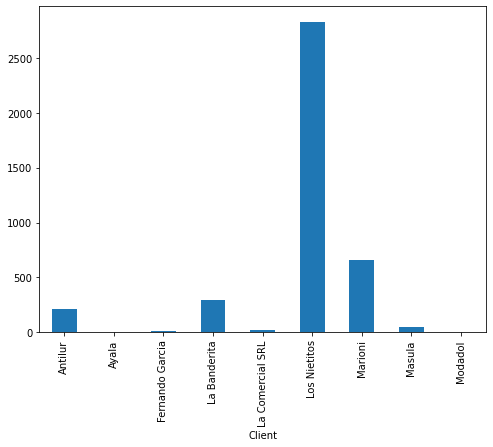

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Client').OCR_text.count().plot.bar(ylim=0)
plt.show()

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=2, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df.OCR_text).toarray()
labels = df.Category_Id
features.shape

(4082, 29239)

In [21]:
for cat in df['Client'].unique():
    mark = df['Client'] == cat
    value_count = df[mark]['Client'].index.tolist()[0]
    print(f"{cat}\n{value_count}\n")

Marioni
0

Antilur
656

Ayala
868

Los Nietitos
875

Fernando Garcia
3701

La Banderita
3712

Masula
4004

Modadol
4056

La Comercial SRL
4063



In [48]:
from sklearn.cluster import KMeans
import numpy as np
n = np.shape(features)[1]
centroids = np.zeros((9, n))
centroids[0] = features[0]
centroids[1] = features[656]
centroids[2] = features[868]
centroids[3] = features[875]
centroids[4] = features[3701]
centroids[5] = features[3712]
centroids[6] = features[4004]
centroids[7] = features[4056]
centroids[8] = features[4063]
#centroids = np.array(centroids, dtype=float)
print(centroids)
kmeans = KMeans(n_clusters=9, init=centroids, random_state=42)
kmeans.fit(features)

[[0.07294853 0.0668234  0.         ... 0.         0.         0.        ]
 [0.04267607 0.03088798 0.         ... 0.         0.         0.        ]
 [0.03776713 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.07240958 0.         0.         ... 0.         0.         0.        ]
 [0.06947794 0.         0.         ... 0.         0.         0.        ]
 [0.02008175 0.         0.         ... 0.         0.         0.        ]]


/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_kmeans.py:1146: RuntimeWarning: Explicit initial center position passed: performing only one init in KMeans instead of n_init=10.
  self._check_params(X)


KMeans(init=array([[0.07294853, 0.0668234 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04267607, 0.03088798, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03776713, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.07240958, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06947794, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.02008175, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]]),
       n_clusters=9, random_state=42)

In [55]:
df['cluster'] = kmeans.labels_

In [50]:
for cat in df['cluster'].unique():
    mark = df['cluster'] == cat
    value_count = df[mark]['Client'].value_counts()
    value_count = value_count.index.tolist()
    print(f"{cat}\n{value_count}\n")

0
['Marioni']

2
['Marioni', 'Ayala', 'La Banderita', 'Los Nietitos', 'Antilur']

1
['Antilur']

3
['Los Nietitos', 'La Banderita']

4
['Fernando Garcia']

5
['La Banderita']

6
['Masula']

7
['Modadol']

8
['La Comercial SRL']



In [51]:
df

,Client,OCR_text,Category_Id,cluster
0,Marioni,vendedor 23-01-2008 02.003823.0016. por 7696-r...,0,0
1,Marioni,| numero vendedor pimalan guerra 0 credito 540...,0,0
2,Marioni,cliente filco s.a total desc. tipo de docunent...,0,0
3,Marioni,para maquinaria agricola - tornille ferrecar l...,0,0
4,Marioni,cliente perez ortiz jose lte telefono 136276 i...,0,0
...,...,...,...,...
4077,La Comercial SRL,de | a comercial s.r.l. rut 212100540011 @ ram...,8,8
4078,La Comercial SRL,vou la comercial s.r.l. rut 212100540011 @ efa...,8,8
4079,La Comercial SRL,"vena do | a comercial s.r.l. @ castriz 2620, l...",8,8
4080,La Comercial SRL,y venta de comercial s.r.l. rut 212100540011 @...,8,8


In [52]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(features)

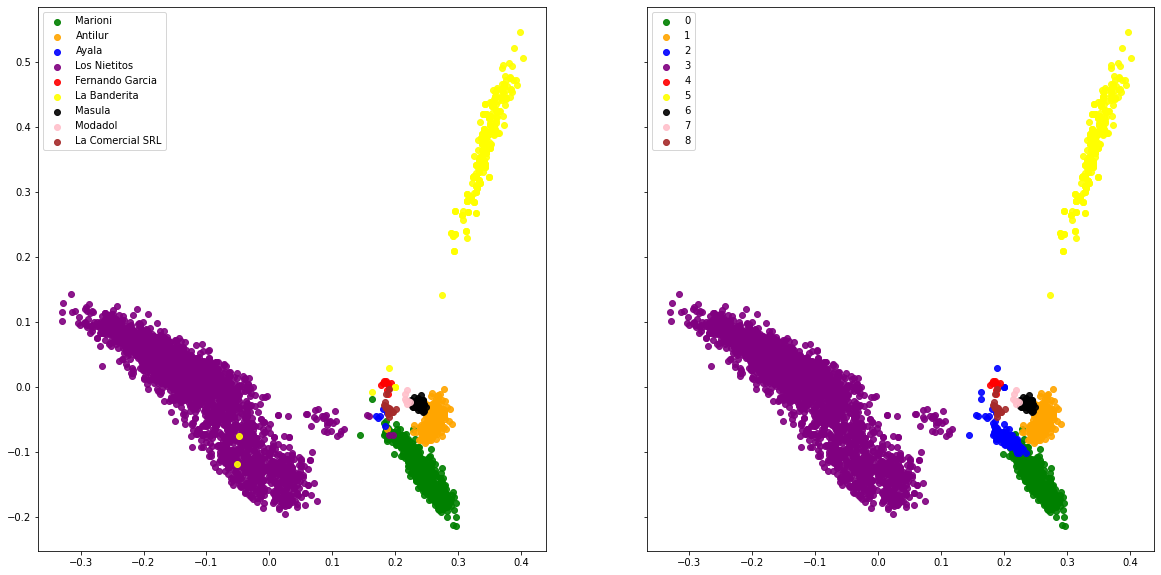

In [53]:
fig, axes = plt.subplots(1, 2, sharey=True)
fig.set_size_inches(20, 10)
categories = df['Client'].unique()
colors = ['green','orange', 'blue', 'purple', 'red','yellow','black','pink','brown']
for i, e in enumerate(categories):
    mark = df['Client'] == e
    axes[0].scatter(x_pca[:, 0][mark], x_pca[:, 1][mark], color=colors[i], label=e, alpha=0.9)
axes[0].legend();
# use the same set of colors as above to compare side to side of the two graphs
colors = ['green','orange', 'blue', 'purple', 'red','yellow','black','pink','brown']
for e in set(kmeans.labels_):
    mark = kmeans.labels_ == e
    axes[1].scatter(x_pca[:, 0][mark], x_pca[:, 1][mark], color=colors[e], label=e, alpha=0.9)
axes[1].legend()

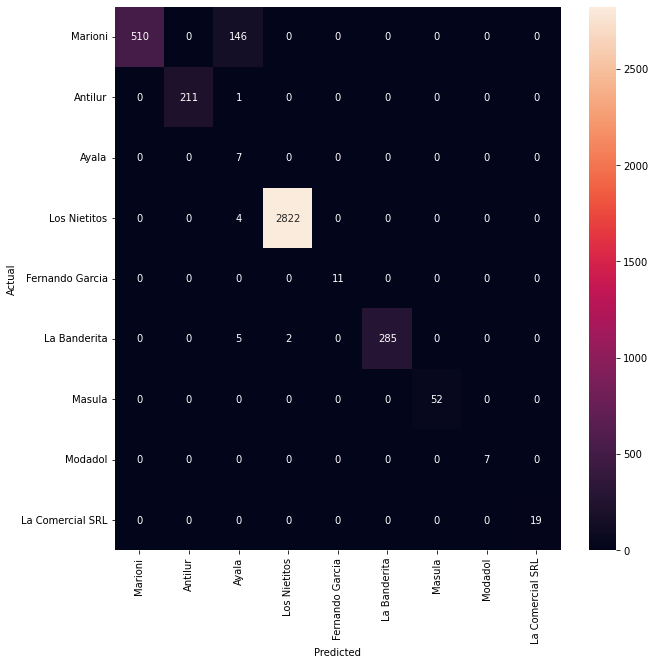

In [59]:
y_test = df["Category_Id"]
y_pred = df["cluster"]
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10,10))
import seaborn as sns
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.Client.values, yticklabels=category_id_df.Client.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [61]:
f1_score(y_test, y_pred,average='macro') 

0.882397867119495